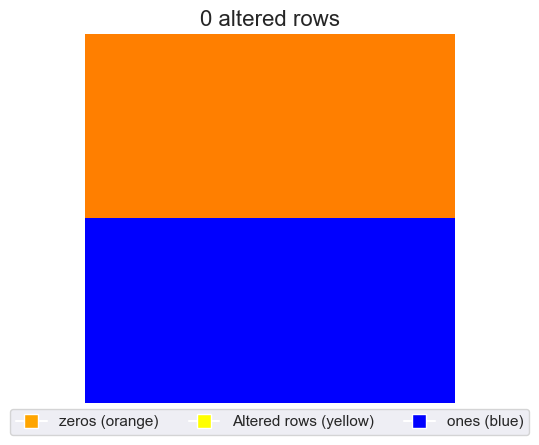

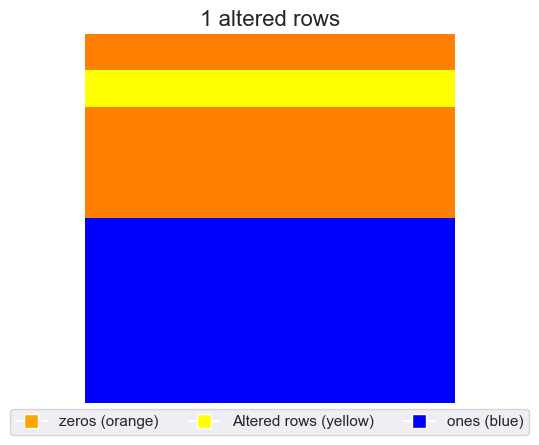

/Users/andreaspagnolo/miniforge3/lib/python3.10/site-packages/gap_statistic/optimalK.py:290: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  centroids, labels = self.clusterer(


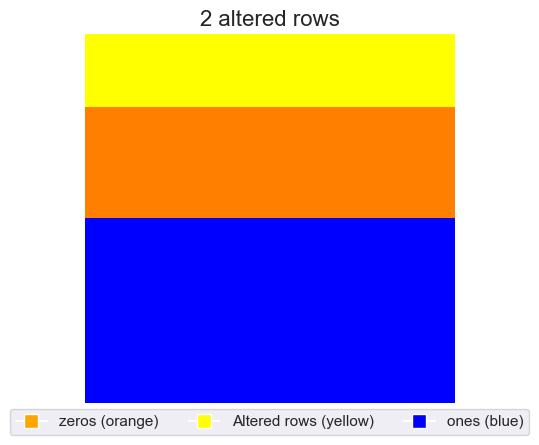

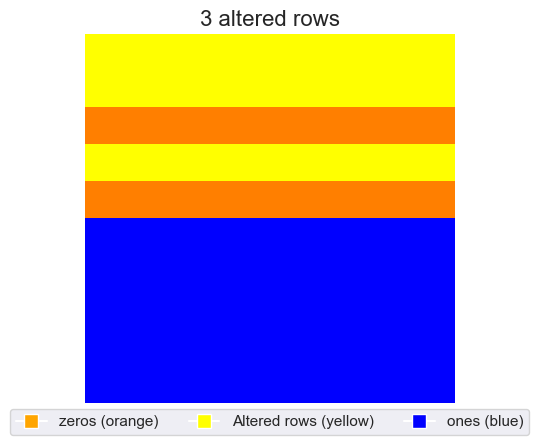

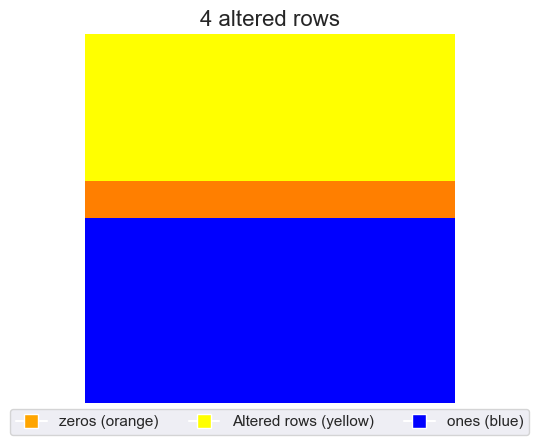

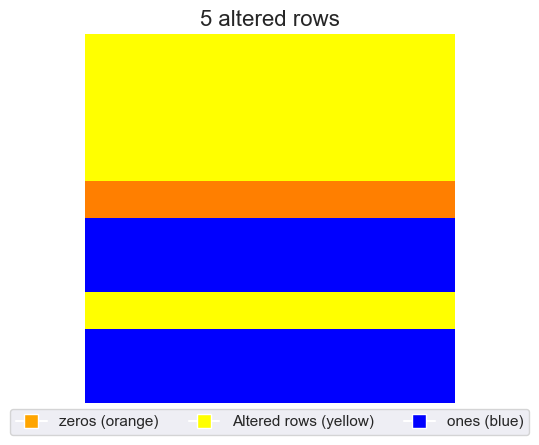

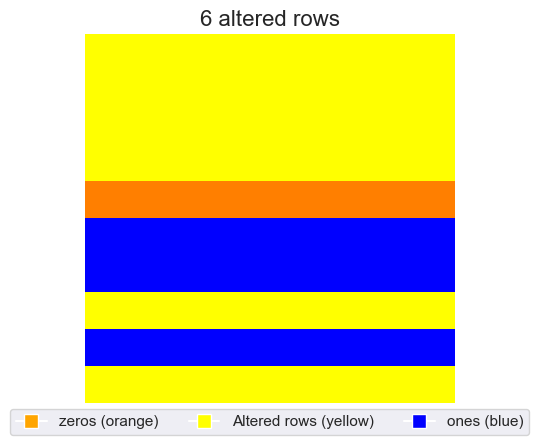

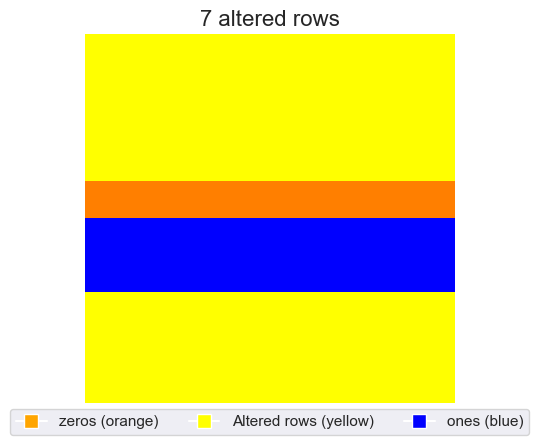

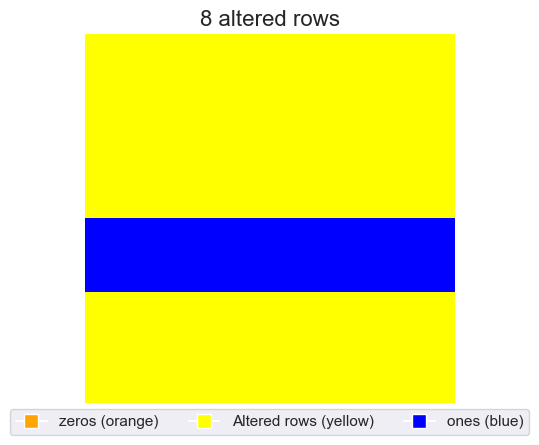

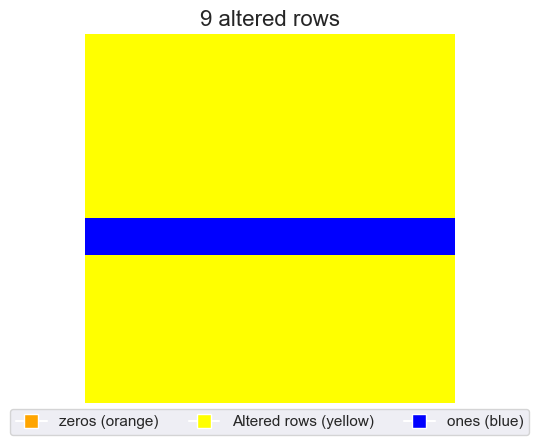

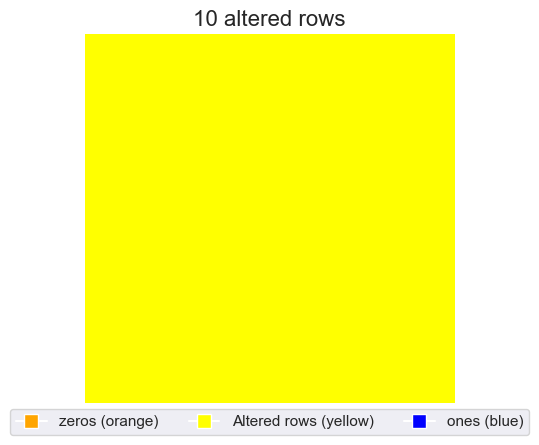

Silhouette Scores:
0.9518276108089003
0.8987958116074296
0.8372083882429803
0.8173280781236265
0.7811538175245445
0.7374052865228508
0.6932537259768426
0.6932958396583072
0.6647841426664047
0.633980633706172

Complementary Entropy Scores:
0.004621561179774192
0.018546104966346344
0.023499531242175853
0.06593194462450891
0.03520045149491269
0.007225546012191719
0.000288558247189985
0.001154464004798239
0.004621561179774192
0.01418496282108006

Calinski Harabasz Scores:
4168.391582177583
1776.523269540533
889.8183369288629
758.5752460870727
645.998329141548
527.7323468322999
426.71922098083536
427.0693422074707
374.0016913284106
312.63604204266784

Reciprocal Davies-Bouldin Scores:
12.666834280441138
6.070622318490338
3.8699550801299343
3.39803806598964
3.0200782852007912
2.697329790661748
2.41937921721527
2.4521030569003934
2.2948149615574738
2.1055704061426743

Dunn-Index Scores:
1.548001978309846
0.2431287338272567
0.13872798410167897
0.13872798410167897
0.13872798410167897
0.13872798

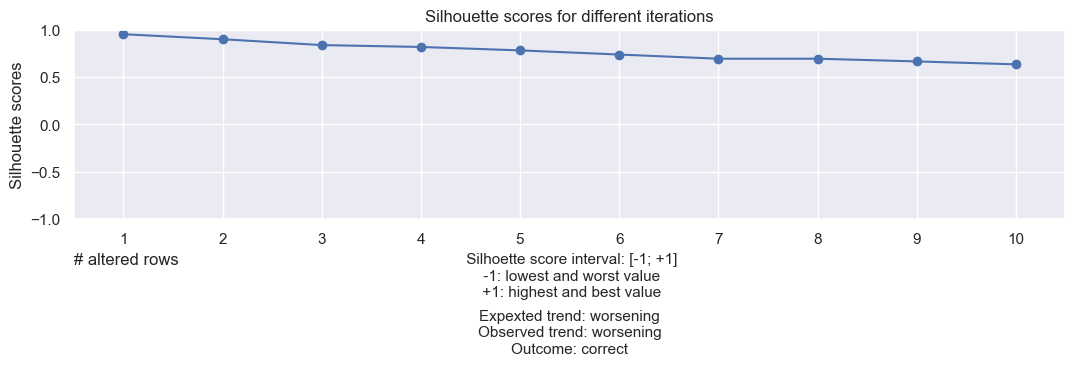

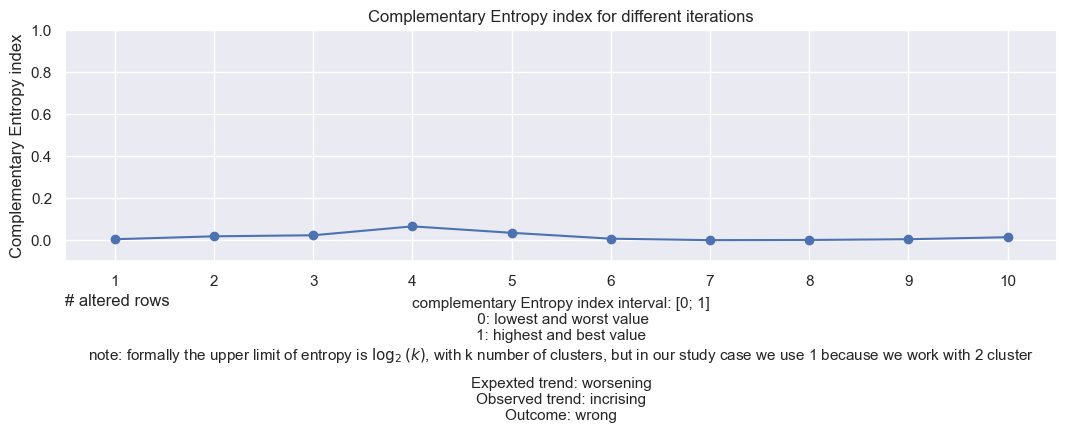

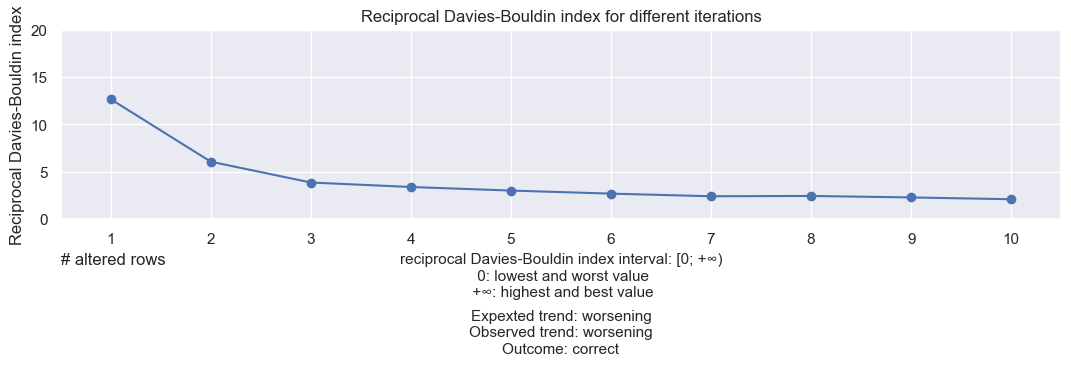

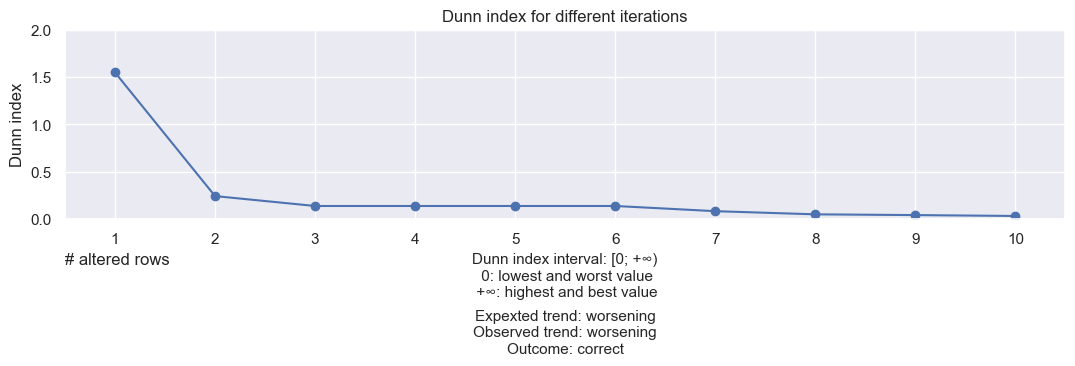

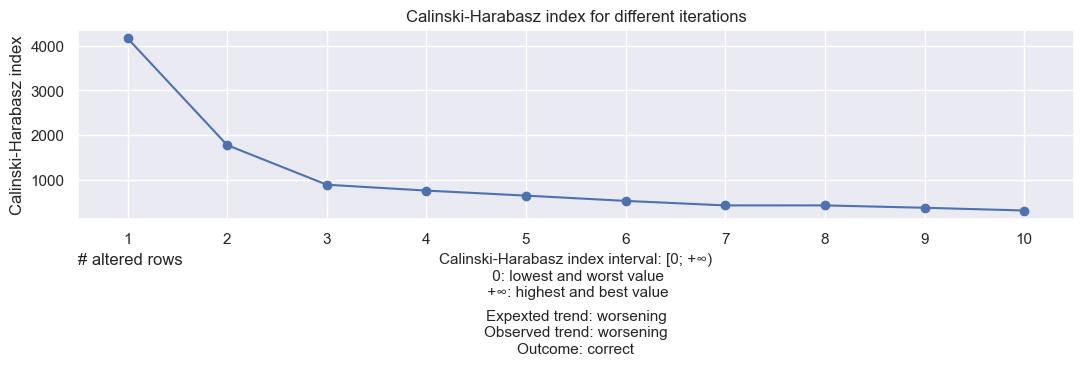

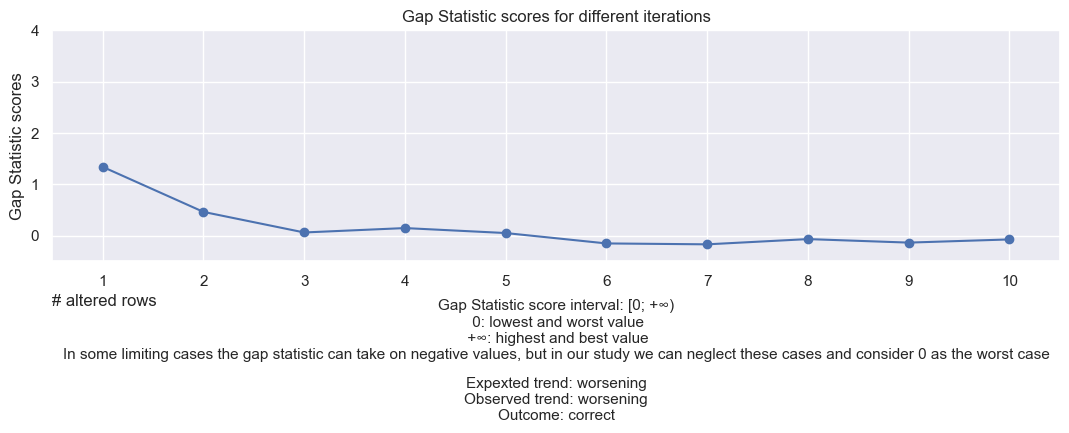

metric,result,time
Silhouette,correct,1.214 ms
Complementary Entropy,wrong,0.625 ms
Reciprocal Davies-Bouldin,correct,0.535 ms
Dunn index,correct,0.282 ms
Calinski-Harabasz,correct,1.154 ms
Gap Statistic,correct,318.243 ms


Report:
I expect the metrics to get worse as more rows changed. This happened with all the metrics except Entropy and Dunn index which always remains constant.
In particular, the Silhouette worsens as the number of modified lines increases, but I expected a more evident deterioration.
Gap statistic instead worsens as we expected, but has a slightly irregular trend.


In [26]:
import random
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pandas as pd

#library for Entropy calculation
from scipy.stats import entropy

#library for Calinski-Harabasz score calculation
from sklearn.metrics import calinski_harabasz_score

#library for davies_bouldin score calculation
from sklearn.metrics import davies_bouldin_score

#library for table style
from IPython.display import display, HTML

from gap_statistic import OptimalK
from sklearn.metrics import pairwise_distances

#python font increase library
from termcolor import colored

#function for dunn_index score calculation
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    min_intercluster_distance = np.inf
    max_intracluster_diameter = -np.inf

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i_points = X[labels == unique_labels[i]]
            cluster_j_points = X[labels == unique_labels[j]]
            
            # Calculate the minimum distance between clusters
            intercluster_distance = np.min(pairwise_distances(cluster_i_points, cluster_j_points))
            min_intercluster_distance = min(min_intercluster_distance, intercluster_distance)

        # Calculate the maximum intra-cluster diameter
        intracluster_diameter = np.max(pairwise_distances(X[labels == unique_labels[i]]))
        max_intracluster_diameter = max(max_intracluster_diameter, intracluster_diameter)
    
        return min_intercluster_distance / max_intracluster_diameter

def check_threshold_change(big, small,trend, threshold):
    if trend == "worsening":
        if big - small > threshold:
            return 0
        else:
            return 1
    else:
        if small - big > threshold:
            return 0
        else:
            return 1

def determine_trend(array, trend, threshold = 0.10):

    minimum = min(array)
    maximum = max(array)

    first, last = array[0], array[-1]
    
    # Calcolo della variazione percentuale tra il minimo e il massimo elemento
    change = (minimum - maximum)

    threshold = change * threshold
    
    if abs(maximum - minimum) < 0.05:
        return "unchanged"
    #if ((maximum - minimum) / maximum) < 0.30:
        #return "unchanged"
    if trend == "worsening" and last > first:
        return "incrising"
    if  trend == "incrising" and first > last:
        return "worsening"

    # Verifica delle variazioni interne all'array con la soglia
    trovato = 0
    for i in range(1, len(array)):
        internal_change = check_threshold_change(array[i-1], array[i],trend, threshold)
        trovato += internal_change
    if trovato > 1:
        return "irregula trend"
    
    if trend == "worsening":
        return "worsening"
    else:
        return "increasing"

#set plot style with default seaborn style
sns.set()

silhouette_scores = []  
entropy_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
dunn_index_scores = [] 
gap_scores = []

tempo_di_calcolo_silhouette = 0
tempo_di_calcolo_entropy = 0
tempo_di_calcolo_calinski_harabasz = 0
tempo_di_calcolo_davies_bouldin = 0
tempo_di_calcolo_dunn_index = 0
tempo_di_calcolo_gap = 0

#variable for metric trend
silhouette_appo = 0
entropy_appo = 0
calinski_harabasz_appo = 0
davies_bouldin_appo = 0
dunn_index_appo = 0
gap_appo = 0


def color_matrix(matrix):
    colored_matrix = np.zeros(matrix.shape + (3,), dtype=float)

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] == 0:
                colored_matrix[i, j] = [1, 0.5, 0]  # Arancione
            elif matrix[i, j] == 1:
                colored_matrix[i, j] = [0, 0, 1]  # Blu
            elif 0 < matrix[i, j] < 1:
                colored_matrix[i, j] = [1, 1, 0]  # Giallo
            else:
                colored_matrix[i, j] = [1, 1, 1]  # Bianco come valore predefinito

    return colored_matrix

#create matrix 
n=10
matrice = np.zeros((n, n))
meta=n//2
matrice[meta:] = 1

righe_da_modificare = list(range(n))
trovato=0
count = 0

i=0


colored_matrix = color_matrix(matrice)
plt.imshow(np.zeros_like(matrice), cmap='gray')  
plt.imshow(colored_matrix, cmap='rainbow', interpolation='nearest')  
plt.axis('off')
plt.title(str(i)+" altered rows", fontsize=16),
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=10, label='zeros (orange)'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='yellow', markersize=10, label='Altered rows (yellow)'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='ones (blue)')
]
plt.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()


# Add random numbers to cells containing 0 in the zero_array
while righe_da_modificare:
    indice_riga = random.choice(righe_da_modificare)
    righe_da_modificare.remove(indice_riga)

    tempi_di_calcolo = np.empty((6, 10))
    
    for j in range(n):
        if matrice[indice_riga, j] == 0 or matrice[indice_riga, j] == 1:
            matrice[indice_riga, j] = random.random()
            trovato = trovato + 1
    
    if trovato > 0:
        colored_matrix = color_matrix(matrice)
        count = count +1


        i +=1
        plt.imshow(np.zeros_like(matrice), cmap='gray')  
        plt.imshow(colored_matrix, cmap='rainbow', interpolation='nearest')  
        plt.axis('off')  # Rimuove gli assi
        plt.title(str(i)+" altered rows", fontsize=16),
        legend_elements = [
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=10, label='zeros (orange)'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='yellow', markersize=10, label='Altered rows (yellow)'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='ones (blue)')
        ]
        plt.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=3)
        plt.show()        

    trovato=0

    # Transform the zero_matrix into a numpy array and then into a vector
    vector = np.array(matrice).flatten()

    # Apply the K-Means algorithm with k=2
    kmeans = KMeans(n_clusters=2, n_init=2, random_state=30)
    kmeans.fit(vector.reshape(-1, 1))  
    # Get cluster labels
    l= kmeans.labels_

    start_time = time.time()
    silhouette_avg = silhouette_score(vector.reshape(-1, 1), l)
    silhouette_scores.append(silhouette_avg)
    end_time = time.time()
    tempo_di_calcolo = end_time - start_time
    tempo_di_calcolo_silhouette = tempo_di_calcolo_silhouette + tempo_di_calcolo
    
    start_time = time.time()
    entropy_val = entropy(np.bincount(l) / len(l), base=2)
    entropy_val = abs(1 - entropy_val)
    entropy_scores.append(entropy_val)
    end_time = time.time()
    tempo_di_calcolo = end_time - start_time
    tempo_di_calcolo_entropy = tempo_di_calcolo_entropy + tempo_di_calcolo
    
    start_time = time.time()
    calinski_harabasz_index = calinski_harabasz_score(vector.reshape(-1, 1), l)
    calinski_harabasz_scores.append(calinski_harabasz_index)
    end_time = time.time()
    tempo_di_calcolo = end_time - start_time
    tempo_di_calcolo_calinski_harabasz = tempo_di_calcolo_calinski_harabasz + tempo_di_calcolo
    
    start_time = time.time()
    davies_bouldin_avg = davies_bouldin_score(vector.reshape(-1, 1), l)
    davies_bouldin_avg = 1 / davies_bouldin_avg
    davies_bouldin_scores.append(davies_bouldin_avg)
    end_time = time.time()
    tempo_di_calcolo = end_time - start_time
    tempo_di_calcolo_davies_bouldin = tempo_di_calcolo_davies_bouldin + tempo_di_calcolo
    
    start_time = time.time()
    dunn_score = dunn_index(vector.reshape(-1, 1), l)
    dunn_index_scores.append(dunn_score)
    end_time = time.time()
    tempo_di_calcolo = end_time - start_time
    tempo_di_calcolo_dunn_index = tempo_di_calcolo_dunn_index + tempo_di_calcolo
    
    start_time = time.time()
    optimal_k = OptimalK(parallel_backend='joblib')
    n_clusters = optimal_k(vector.reshape(-1, 1), cluster_array=np.arange(1, 3))
    gap_df = optimal_k.gap_df
    optimal_gap_statistic = gap_df.loc[gap_df.gap_value.idxmax(), 'gap_value']
    gap_scores.append(optimal_gap_statistic)
    end_time = time.time()
    tempo_di_calcolo = end_time - start_time
    tempo_di_calcolo_gap = tempo_di_calcolo_gap + tempo_di_calcolo


print("Silhouette Scores:")
for score in silhouette_scores:
    print(score)

print("\nComplementary Entropy Scores:")
for score in entropy_scores:
    print(score)
    
print("\nCalinski Harabasz Scores:")
for score in calinski_harabasz_scores:
    print(score)

print("\nReciprocal Davies-Bouldin Scores:")
for score in davies_bouldin_scores:
    print(score)
    
print("\nDunn-Index Scores:")
for score in dunn_index_scores:
    print(score)
    
print("\nGap Scores:")
for score in gap_scores:
    print(score)

# Save metric values to a txt file
with open("../result/result_matrix/metrics_values_matrix.txt", "w") as file:
    file.write("Silhouette Scores:\n")
    for score in silhouette_scores:
        file.write(str(score) + "\n")

    file.write("\nComplementary Entropy Scores:\n")
    for score in entropy_scores:
        file.write(str(score) + "\n")

    file.write("\nCalinski Harabasz Scores:\n")
    for score in calinski_harabasz_scores:
        file.write(str(score) + "\n")

    file.write("\nReciprocal Davies-Bouldin Scores:\n")
    for score in davies_bouldin_scores:
        file.write(str(score) + "\n")

    file.write("\nDunn-Index Scores:\n")
    for score in dunn_index_scores:
        file.write(str(score) + "\n")

    file.write("\nGap Scores:\n")
    for score in gap_scores:
        file.write(str(score) + "\n")

# Define expected trend
expext_trend = "worsening"

# Silhouette Score
appo = determine_trend(silhouette_scores, "worsening")
if appo == "unchanged" or appo == "irregular trend":
    appo = "wrong"
result_Silhouette = "correct" if appo == expext_trend else "wrong"

# Entropy Score
appo = determine_trend(entropy_scores, "worsening")
if appo == "unchanged" or appo == "irregular trend":
    appo = "wrong"
result_Entropy = "correct" if appo == expext_trend else "wrong"

# Davies-Bouldin Score
appo = determine_trend(davies_bouldin_scores, "worsening")
if appo == "unchanged" or appo == "irregular trend":
    appo = "wrong"
result_Davies_Bouldin = "correct" if appo == expext_trend else "wrong"

# Dunn Index
appo = determine_trend(dunn_index_scores, "worsening")
if appo == "unchanged" or appo == "irregular trend":
    appo = "wrong"
result_Dunn = "correct" if appo == expext_trend else "wrong"

# Calinski-Harabasz Score
appo = determine_trend(calinski_harabasz_scores, "worsening")
if appo == "unchanged" or appo == "irregular trend":
    appo = "wrong"
result_Calinski_Harabasz = "correct" if appo == expext_trend else "wrong"

# Gap Statistic
appo = determine_trend(gap_scores, "worsening")
if appo == "unchanged" or appo == "irregular trend":
    appo = "wrong"
result_Gap = "correct" if appo == expext_trend else "wrong"   
    
rows_alteration = np.arange(1, 11)

# Plot of Silhouette variations
plt.figure(figsize=(11, 5))
plt.plot(rows_alteration, silhouette_scores, marker='o')
plt.title('Silhouette scores for different iterations')
plt.xlabel('# altered rows', loc='left')
plt.ylabel('Silhouette scores')
text = ' Silhoette score interval: [-1; +1]\n -1: lowest and worst value\n +1: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = f'Expexted trend: worsening\nObserved trend: {determine_trend(silhouette_scores,"worsening")}\nOutcome: {result_Silhouette}'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
file_path = '../result/result_matrix/variazioni_Silhouette_matrix.pdf'
plt.xticks(np.arange(1, 11))
plt.ylim(-1, 1)
plt.xlim(0.5, 10.5)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Entropy variations
plt.figure(figsize=(12.8, 3))  # Impostazione larghezza e altezza del plot
plt.plot(rows_alteration, entropy_scores, marker='o')
plt.title('Complementary Entropy index for different iterations')
plt.xlabel('# altered rows', loc='left')
plt.ylabel('Complementary Entropy index')
text='complementary Entropy index interval: [0; 1]\n 0: lowest and worst value\n1: highest and best value\n'+ 'note: formally the upper limit of entropy is $\log_{2}(k)$, with k number of clusters, but in our study case we use 1 because we work with 2 cluster'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = f'Expexted trend: worsening\nObserved trend: {determine_trend(entropy_scores,"worsening")}\nOutcome: {result_Entropy}'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
plt.xticks(np.arange(1, 11))
plt.ylim(-0.1, 1)
file_path = '../result/result_matrix/variazioni_Entropy_matrix.pdf'
plt.xlim(0.5, 10.5)
plt.savefig(file_path)
plt.show()


# Plot of Davies_Bouldin variations
plt.figure(figsize=(11, 5))
plt.plot(rows_alteration, davies_bouldin_scores, marker='o')
plt.title('Reciprocal Davies-Bouldin index for different iterations')
plt.xlabel('# altered rows',loc='left')
plt.ylabel('Reciprocal Davies-Bouldin index')
text='reciprocal Davies-Bouldin index interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = f'Expexted trend: worsening\nObserved trend: {determine_trend(davies_bouldin_scores,"worsening")}\nOutcome: {result_Davies_Bouldin}'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
plt.xticks(np.arange(1, 11))
plt.ylim(0, 20)
plt.xlim(0.5, 10.5)
plt.tight_layout()
file_path = '../result/result_matrix/variazioni_Davies_Bouldin_matrix.pdf'
plt.savefig(file_path)
plt.show()

# Plot of Dunn_index variations
plt.figure(figsize=(11, 5))
plt.plot(rows_alteration, dunn_index_scores, marker='o')
plt.title('Dunn index for different iterations')
plt.xlabel('# altered rows',loc='left')
plt.ylabel('Dunn index')
text = 'Dunn index interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
text2 = f'Expexted trend: worsening\nObserved trend: {determine_trend(dunn_index_scores,"worsening")}\nOutcome: {result_Dunn}'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
plt.xticks(np.arange(1, 11))
plt.ylim(0, 2)
plt.xlim(0.5, 10.5)
plt.tight_layout()
file_path = '../result/result_matrix/variazioni_Dunn_index_matrix.pdf'
plt.savefig(file_path)
plt.show()

# Plot of Calinski_Harabasz Scores variations
plt.figure(figsize=(11, 5))
plt.plot(rows_alteration, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz index for different iterations')
plt.xlabel('# altered rows', loc='left')
plt.ylabel('Calinski-Harabasz index')
text ='\nCalinski-Harabasz index interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value\n'
text2 = f'Expexted trend: worsening\nObserved trend: {determine_trend(calinski_harabasz_scores,"worsening")}\nOutcome: {result_Calinski_Harabasz}'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.xticks(np.arange(1, 11))
plt.grid(True)
plt.xlim(0.5, 10.5)
plt.tight_layout()
file_path = '../result/result_matrix/variazioni_Calinski_Harabasz_matrix.pdf'
plt.savefig(file_path)
plt.show()

# Plot of Gap Statistic variations
plt.figure(figsize=(13, 3))
plt.plot(rows_alteration, gap_scores, marker='o')
plt.title('Gap Statistic scores for different iterations')
plt.xlabel('# altered rows', loc='left')
plt.ylabel('Gap Statistic scores')
text = 'Gap Statistic score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value\nIn some limiting cases the gap statistic can take on negative values, but in our study we can neglect these cases and consider 0 as the worst case' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
text2 = f'Expexted trend: worsening\nObserved trend: {determine_trend(gap_scores,"worsening")}\nOutcome: {result_Gap}'
plt.text(0.5, -0.6, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.grid(True)
plt.xticks(np.arange(1, 11))
plt.xlim(0.5, 10.5)
plt.ylim(-0.5, 4)
file_path = '../result/result_matrix/variazioni_Gap_Statistic_matrix.pdf'
plt.savefig(file_path)
plt.show()

tempo_di_calcolo_silhouette = tempo_di_calcolo_silhouette / n          
tempo_di_calcolo_entropy = tempo_di_calcolo_entropy / n
tempo_di_calcolo_calinski_harabasz = tempo_di_calcolo_calinski_harabasz / n
tempo_di_calcolo_davies_bouldin = tempo_di_calcolo_davies_bouldin / n
tempo_di_calcolo_dunn_index = tempo_di_calcolo_dunn_index / n
tempo_di_calcolo_gap = tempo_di_calcolo_gap / n

for i in range(0,1):
    tempi_di_calcolo[0, i] = round(tempo_di_calcolo_silhouette * 1000, 3)
    tempi_di_calcolo[1, i] = round(tempo_di_calcolo_entropy * 1000, 3)
    tempi_di_calcolo[2, i] = round(tempo_di_calcolo_davies_bouldin * 1000, 3)
    tempi_di_calcolo[3, i] = round(tempo_di_calcolo_dunn_index * 1000, 3)
    tempi_di_calcolo[4, i] = round(tempo_di_calcolo_calinski_harabasz * 1000, 3)
    tempi_di_calcolo[5, i] = round(tempo_di_calcolo_gap * 1000, 3)

medie_colonne = np.mean(tempi_di_calcolo, axis=0)

file_path="../result/result_matrix/final_result"
table_df = pd.DataFrame(columns=["metric", "result", "time"])

dati_tabella = [
    ["Silhouette", result_Silhouette, str(tempi_di_calcolo[0,0]) + " ms"],
    ["Complementary Entropy", result_Entropy, str(tempi_di_calcolo[1,0]) + " ms"],
    ["Reciprocal Davies-Bouldin", result_Davies_Bouldin, str(tempi_di_calcolo[2,0]) + " ms"],
    ["Dunn index", result_Dunn, str(tempi_di_calcolo[3,0]) + " ms"],
    ["Calinski-Harabasz", result_Calinski_Harabasz, str(tempi_di_calcolo[4,0]) + " ms"],
    ["Gap Statistic", result_Gap, str(tempi_di_calcolo[5,0]) + " ms"]
]


for row_data in dati_tabella:
    table_df.loc[len(table_df)] = row_data
    
#save result in a variable
for riga in dati_tabella:
    if riga[1] == "correct":
        if riga[0] == "Silhouette":
            silhouette_appo += 1
        elif riga[0] == "Entropy":
            entropy_appo += 1
        elif riga[0] == "Calinski-Harabasz":
            calinski_harabasz_appo += 1
        elif riga[0] == "Davies-Bouldin":
            davies_bouldin_appo += 1
        elif riga[0] == "Dunn index":
            dunn_index_appo += 1
        elif riga[0] == "Gap Statistic":
            gap_appo += 1


#table style
table_df.style \
  .format(precision=3, thousands=".", decimal=",").set_properties(**{'text-align': 'left'})

# Save HTML table to file
table_df.to_csv(file_path + ".csv")

html_table = table_df.to_html(index=False, classes="table table-striped", border=0)
html_table = html_table.replace('<table', '<table style="width:100%;" text-align:center;"')
html_table = html_table.replace('<td', '<td style="text-align:center;"').replace('<th', '<th style="text-align:center;"')

#print table
display(HTML(html_table))

testo_grande = colored("Report:", attrs=['bold'])

print(testo_grande)
print("I expect the metrics to get worse as more rows changed. This happened with all the metrics except Entropy and Dunn index which always remains constant.")
print("In particular, the Silhouette worsens as the number of modified lines increases, but I expected a more evident deterioration.")
print("Gap statistic instead worsens as we expected, but has a slightly irregular trend.")
with open("../result/result_matrix/report_matrix.txt", "w") as file:
    file.write("Report:\n")
    file.write("I expect the metrics to get worse as more rows changed. This happened with all the metrics except Entropy which always remains constant")
    file.write("In particular, the Silhouette worsens as the number of modified lines increases, but I expected a more evident deterioration.")
    file.write("Gap statistic instead worsens as we expected, but has a slightly irregular trend.")